In [1]:
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load GeoJSON file
geo_path = 'neighbourhoods.geojson'
with open(geo_path, 'r') as file:
    geo_data = json.load(file)

In [3]:
# Load the cleaned data (Pandas DataFrame)
data_path = '6.2 Exploring Relationships.pkl'
df = pd.read_pickle(data_path)

In [4]:
# Preview the dataset
df.head()

id                                     property_title  host_id  \
0  2595                              Skylit Midtown Castle     2845   
1  5136    Spacious Family Friendly Duplex w/ Patio + Yard     7378   
2  6848                   Only 2 stops to Manhattan studio    15991   
3  6872  Uptown Sanctuary w/ Private Bath (Month to Month)    16104   
4  6990                            UES Beautiful Blue Room    16800   

       host_name       city neighbourhood  latitude  longitude  \
0       Jennifer  Manhattan       Midtown  40.75356  -73.98559   
1        Rebecca   Brooklyn   Sunset Park  40.66265  -73.99454   
2  Allen & Irina   Brooklyn  Williamsburg  40.70935  -73.95342   
3            Kae  Manhattan   East Harlem  40.80107  -73.94255   
4            Cyn  Manhattan   East Harlem  40.78778  -73.94759   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    NaN              30                 49  2022-06-21   
1  Entire home/apt  215.0              30                  4  2023-08-20   
2  Entire home/apt   81.0              30                193  2024-05-18   
3     Private room   65.0              30                  1  2022-06-05   
4     Private room   65.0              30                247  2024-03-06   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.28                               3               300   
1               0.03                               1                71   
2               1.05                               1               193   
3               0.04                               2               365   
4               1.38                               1               212   

   nr_reviews_past_year license avail_month        price_range  
0                     0     NaN     oct-dec         Not listed  
1                     1     NaN     jan-mar  Mid-range product  
2                     3     NaN     jul-sep  Low-range product  
3                     0     NaN     oct-dec  Low-range product  
4                     2     NaN     jul-sep  Low-range product

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37758 entries, 0 to 37757
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              37758 non-null  int64  
 1   property_title                  37758 non-null  object 
 2   host_id                         37758 non-null  int64  
 3   host_name                       37758 non-null  object 
 4   city                            37758 non-null  object 
 5   neighbourhood                   37758 non-null  object 
 6   latitude                        37758 non-null  float64
 7   longitude                       37758 non-null  float64
 8   room_type                       37758 non-null  object 
 9   price                           23044 non-null  float64
 10  minimum_nights                  37758 non-null  int64  
 11  number_of_reviews               37758 non-null  int64  
 12  last_review                     

In [6]:
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


In [7]:
# Check for missing values
print(df.isnull().sum())

id                                    0
property_title                        0
host_id                               0
host_name                             0
city                                  0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             14714
minimum_nights                        0
number_of_reviews                     0
last_review                       11746
reviews_per_month                 11746
calculated_host_listings_count        0
availability_365                      0
nr_reviews_past_year                  0
license                           32587
avail_month                           0
price_range                           0
dtype: int64


In [8]:
df = df.dropna(subset=['price']) 
#14,714 missing values (~39% of the dataset). This column is critical for your choropleth map, so rows with missing prices should be dropped unless you decide to impute them.

In [9]:
# Drop unnecessary columns
df = df.drop(columns=['last_review', 'reviews_per_month', 'license'])

In [10]:
#Filter Out Extreme Values in price : To remove extreme outliers, filter out prices above the 99th percentile:
# Set an upper limit for price
upper_limit = df['price'].quantile(0.99)
df = df[df['price'] <= upper_limit]

In [11]:
print(df.isnull().sum())
print(df.info())
print(df.describe())

id                                0
property_title                    0
host_id                           0
host_name                         0
city                              0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
nr_reviews_past_year              0
avail_month                       0
price_range                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22822 entries, 1 to 37757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              22822 non-null  int64  
 1   property_title                  22822 non-null  object 
 2   host_id               

In [12]:
citi_price = df.groupby(['city','neighbourhood'])['price_range'].count()

In [13]:
citi_price

city           neighbourhood
Bronx          Allerton         33
               Baychester       15
               Belmont          17
               Bronxdale        10
               Castle Hill       6
                                ..
Staten Island  Tottenville       4
               West Brighton    19
               Westerleigh       4
               Willowbrook       2
               Woodrow           3
Name: price_range, Length: 224, dtype: int64

In [14]:
# Group by city, neighborhood, and price_range and count the number of listings
citi_price = df.groupby(['city', 'neighbourhood', 'price_range'], observed=True)['price_range'].count().reset_index(name='listing_count')

# Group by price_range and sum the listing counts to find the most booked price range
price_range_reviews = citi_price.groupby('price_range', observed=True)['listing_count'].sum()

# Find the price range with the highest number of bookings
most_booked_price_range = price_range_reviews.idxmax()
most_booked_price_range_count = price_range_reviews.max()

print("Most booked price range:", most_booked_price_range)
print("Booking count:", most_booked_price_range_count)

Most booked price range: Mid-range product
Booking count: 11652


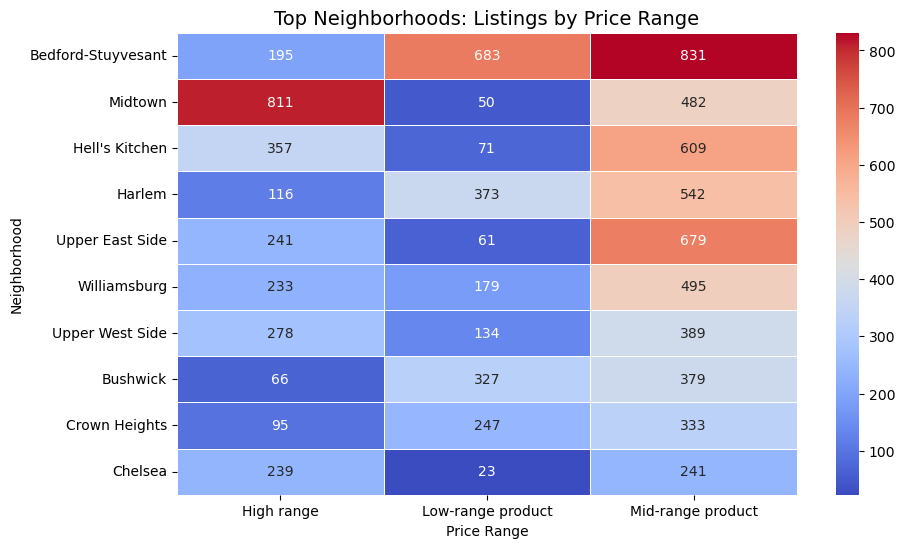

In [15]:
# Filter top neighborhoods with the most listings
top_neighbourhoods = citi_price.groupby('neighbourhood')['listing_count'].sum().nlargest(10).index
filtered_data = citi_price[citi_price['neighbourhood'].isin(top_neighbourhoods)]

# Pivot the data for heatmap
heatmap_q1_data = filtered_data.pivot_table(index='neighbourhood', columns='price_range', values='listing_count', aggfunc='sum', fill_value=0)

# Sort by total listings
heatmap_q1_data = heatmap_q1_data.loc[heatmap_q1_data.sum(axis=1).sort_values(ascending=False).index]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_q1_data, cmap='coolwarm', annot=True, fmt='d', linewidths=0.5)
plt.title('Top Neighborhoods: Listings by Price Range', fontsize=14)
plt.xlabel('Price Range')
plt.ylabel('Neighborhood')
plt.show()


In [16]:
# Group by city and neighborhood to find the most popular neighborhood/city
city_neighbourhood_reviews = citi_price.groupby(['city', 'neighbourhood'])['listing_count'].sum()

# Find the neighborhood with the most bookings
most_popular_neighbourhood = city_neighbourhood_reviews.idxmax()
most_popular_reviews = city_neighbourhood_reviews.max()

print("Most popular neighborhood:", most_popular_neighbourhood)
print("Total reviews in this neighborhood:", most_popular_reviews)


Most popular neighborhood: ('Brooklyn', 'Bedford-Stuyvesant')
Total reviews in this neighborhood: 1709


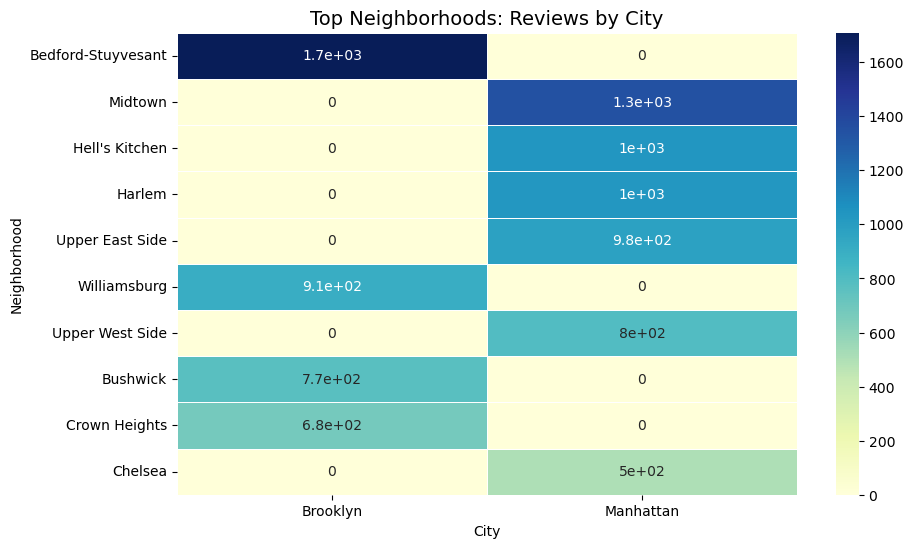

In [17]:
# Filter top neighborhoods
top_neighbourhoods = city_neighbourhood_reviews.nlargest(10).index.get_level_values(1)
filtered_data = city_neighbourhood_reviews.loc[(slice(None), top_neighbourhoods)]

# Convert to DataFrame for heatmap
heatmap_q2_data = filtered_data.reset_index().pivot_table(index='neighbourhood', columns='city', values='listing_count', fill_value=0)

# Sort by total reviews
heatmap_q2_data = heatmap_q2_data.loc[heatmap_q2_data.sum(axis=1).sort_values(ascending=False).index]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_q2_data, cmap='YlGnBu', annot=True, linewidths=0.5)
plt.title('Top Neighborhoods: Reviews by City', fontsize=14)
plt.xlabel('City')
plt.ylabel('Neighborhood')
plt.show()


In [18]:
# Group by city, neighbourhood, room_type, and price_range, and count the number of listings
citi_price_room_type = df.groupby(['city', 'neighbourhood', 'room_type', 'price_range'], observed=True)['price_range'].count().reset_index(name='listing_count')

# Group by room_type and price_range, and sum the listing counts to get the total number of bookings per room type
room_type_reviews = citi_price_room_type.groupby('room_type', observed=True)['listing_count'].sum()

# Find the room type with the most bookings
most_booked_room_type = room_type_reviews.idxmax()
most_booked_room_type_count = room_type_reviews.max()

print("Most booked room type:", most_booked_room_type)
print("Booking count:", most_booked_room_type_count)


Most booked room type: Entire home/apt
Booking count: 12560


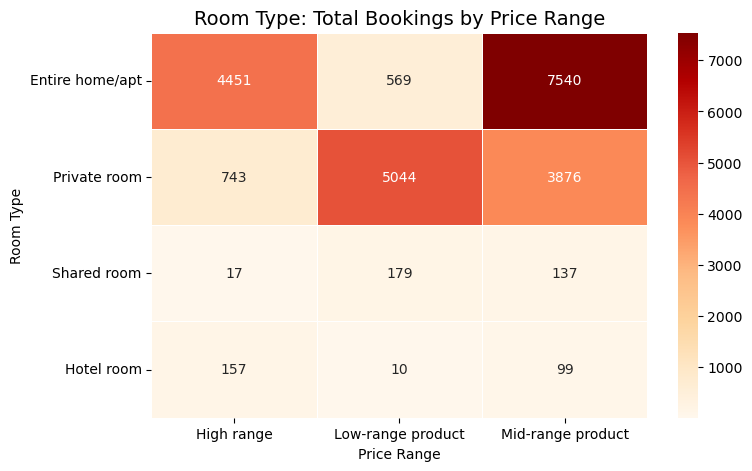

In [19]:
# Filter top room types by total bookings
room_type_reviews_sorted = room_type_reviews.sort_values(ascending=False)
filtered_room_types = room_type_reviews_sorted.index[:5]  # Top 5 room types
filtered_data = citi_price_room_type[citi_price_room_type['room_type'].isin(filtered_room_types)]

# Pivot the data for heatmap
heatmap_q3_data = filtered_data.pivot_table(index='room_type', columns='price_range', values='listing_count', aggfunc='sum', fill_value=0)

# Sort by total bookings
heatmap_q3_data = heatmap_q3_data.loc[heatmap_q3_data.sum(axis=1).sort_values(ascending=False).index]

# Create the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_q3_data, cmap='OrRd', annot=True, fmt='d', linewidths=0.5)
plt.title('Room Type: Total Bookings by Price Range', fontsize=14)
plt.xlabel('Price Range')
plt.ylabel('Room Type')
plt.show()

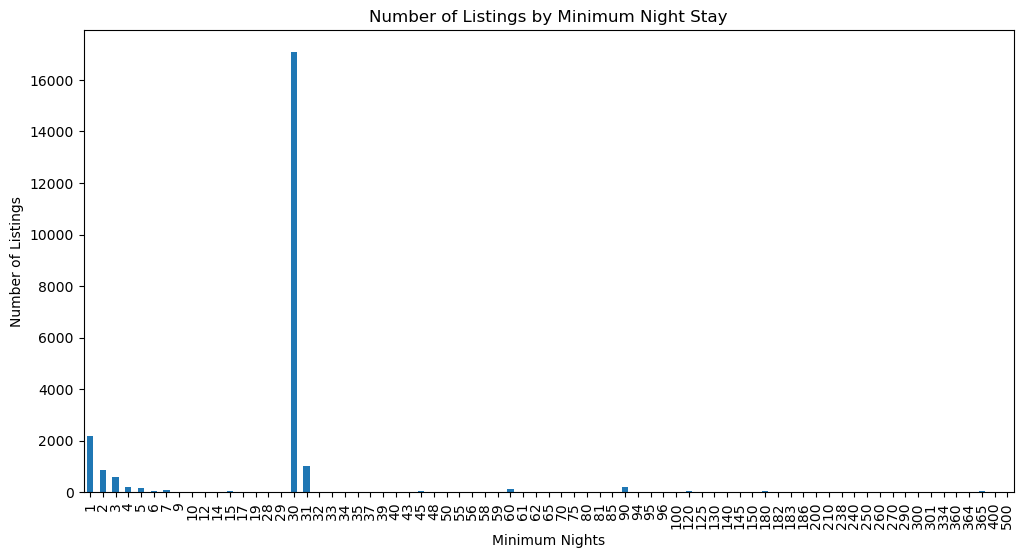

In [20]:
# Add minimum_nights to the citi_price data to analyze the effect
citi_price_min_nights = df.groupby(['city', 'neighbourhood', 'minimum_nights', 'price_range'])['price_range'].count().reset_index(name='listing_count')

# Group by minimum_nights and sum the listing counts
min_nights_reviews = citi_price_min_nights.groupby('minimum_nights')['listing_count'].sum()

# Plot the results to visualize the relationship
import matplotlib.pyplot as plt
min_nights_reviews.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Listings by Minimum Night Stay')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')
plt.show()


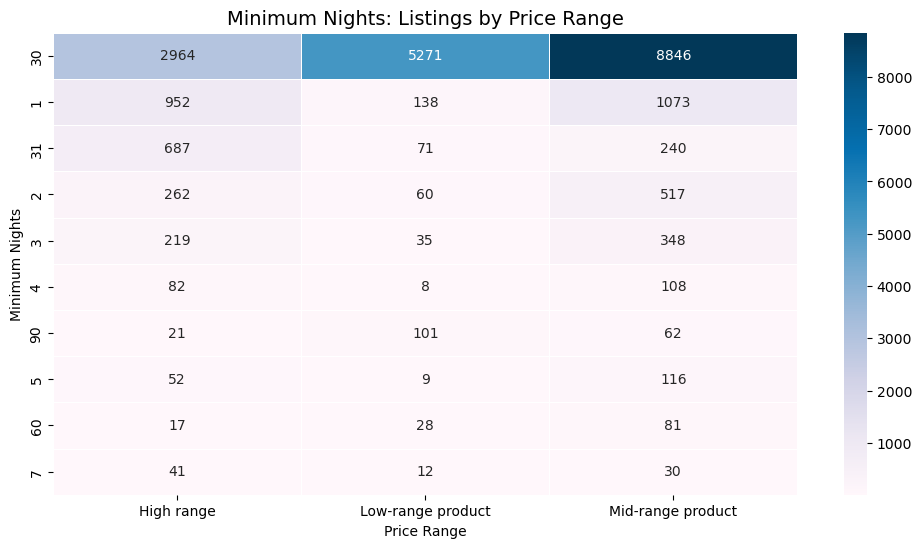

In [21]:
# Filter top minimum nights by listings
top_minimum_nights = min_nights_reviews.nlargest(10).index
filtered_data = citi_price_min_nights[citi_price_min_nights['minimum_nights'].isin(top_minimum_nights)]

# Pivot the data for heatmap
heatmap_q4_data = filtered_data.pivot_table(index='minimum_nights', columns='price_range', values='listing_count', aggfunc='sum', fill_value=0)

# Sort by total listings
heatmap_q4_data = heatmap_q4_data.loc[heatmap_q4_data.sum(axis=1).sort_values(ascending=False).index]

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_q4_data, cmap='PuBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Minimum Nights: Listings by Price Range', fontsize=14)
plt.xlabel('Price Range')
plt.ylabel('Minimum Nights')
plt.show()

In [22]:
citi_price.max()

city                 Staten Island
neighbourhood             Woodside
price_range      Mid-range product
listing_count                  831
dtype: object

In [23]:
citi_price.min()

city                  Bronx
neighbourhood      Allerton
price_range      High range
listing_count             1
dtype: object

In [24]:
citi_price.head()

city neighbourhood        price_range  listing_count
0  Bronx      Allerton         High range              2
1  Bronx      Allerton  Low-range product             16
2  Bronx      Allerton  Mid-range product             15
3  Bronx    Baychester  Low-range product              5
4  Bronx    Baychester  Mid-range product             10

In [25]:
# Process the neighbourhood column
citi_price['neighbourhood'] = citi_price['neighbourhood'].str.lower().str.strip()

In [26]:
# Aggregate counts by neighbourhood
neighbourhood_data = citi_price.groupby('neighbourhood')['price_range'].sum().reset_index()

In [27]:
# Inspect the GeoJSON to find the key for matching
print(geo_data['features'][0]['properties'])  # Check available properties

{'neighbourhood': 'Bayswater', 'neighbourhood_group': 'Queens'}


In [28]:
# Create the base map
latitude = df['latitude'].mean()
longitude = df['longitude'].mean()
m = folium.Map(location=[latitude, longitude], zoom_start=12)

In [29]:
# Ensure `price_range` is numeric
neighbourhood_data['price_range'] = pd.to_numeric(neighbourhood_data['price_range'], errors='coerce')

# Fill missing values in `price_range` with 0
neighbourhood_data['price_range'].fillna(0, inplace=True)

# Ensure consistent case or formatting between GeoJSON and DataFrame
neighbourhood_data['neighbourhood'] = neighbourhood_data['neighbourhood'].str.lower()
geo_data['features'] = [
    {
        **feature,
        "properties": {
            **feature["properties"],
            "neighbourhood": feature["properties"]["neighbourhood"].lower(),
        },
    }
    for feature in geo_data["features"]
]

# Initialize the map
m = folium.Map(location=[1, 1], zoom_start=5)

# Add the choropleth layer
folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=neighbourhood_data,
    columns=["neighbourhood", "price_range"],
    key_on="feature.properties.neighbourhood",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Listings by Neighborhood"
).add_to(m)

# Add tooltips to show more information about each neighborhood
folium.GeoJson(
    geo_data,
    name="neighbourhood_tooltip",
    tooltip=folium.GeoJsonTooltip(
        fields=["neighbourhood"],
        aliases=["Neighbourhood:"],
        localize=True
    )
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save("neighbourhood_listings.html")

print("Map saved as 'neighbourhood_listings.html'")


Map saved as 'neighbourhood_listings.html'


In [30]:
m

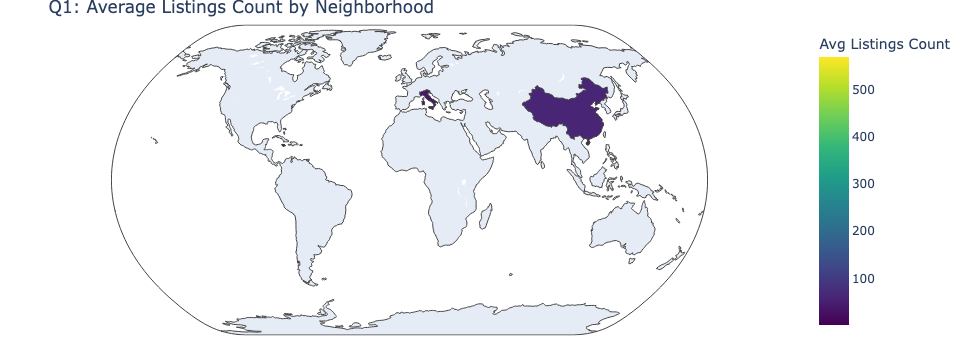

In [31]:
# Import necessary libraries
import plotly.express as px
import pandas as pd

# Q1: Average Listings Count by Neighborhood
avg_listing_per_neighbourhood = citi_price.groupby('neighbourhood')['listing_count'].mean().reset_index()
fig_q1 = px.choropleth(avg_listing_per_neighbourhood,
                       locations='neighbourhood',
                       locationmode='country names',
                       color='listing_count',
                       hover_name='neighbourhood',
                       color_continuous_scale='Viridis',
                       projection='natural earth',
                       labels={'listing_count': 'Avg Listings Count'},
                       title='Q1: Average Listings Count by Neighborhood')
fig_q1.update_layout(margin={"r": 25, "t": 25, "l": 25, "b": 25})

# Display the figures
fig_q1.show()

In [32]:
# Check the first few rows of the DataFrame to understand its structure
print(heatmap_q2_data.head())

# Print all column names to see how cities are represented
print(heatmap_q2_data.columns)


city                Brooklyn  Manhattan
neighbourhood                          
Bedford-Stuyvesant    1709.0        0.0
Midtown                  0.0     1343.0
Hell's Kitchen           0.0     1037.0
Harlem                   0.0     1031.0
Upper East Side          0.0      981.0
Index(['Brooklyn', 'Manhattan'], dtype='object', name='city')


In [33]:
print(heatmap_q2_data.columns)
# Example: Update 'neighbourhood' to the correct column name if necessary
heatmap_q2_data_melted = heatmap_q2_data.melt(id_vars=['Neighborhood'], value_vars=['Brooklyn', 'Manhattan'], 
                                              var_name='city', value_name='reviews')

# Group by 'city' and compute the average reviews for each city
avg_reviews_per_city = heatmap_q2_data_melted.groupby('city')['reviews'].mean().reset_index(name='avg_reviews')

# Create the choropleth map
fig_q2 = px.choropleth(avg_reviews_per_city,
                       locations='city',
                       locationmode='country names',
                       color='avg_reviews',
                       hover_name='city',
                       color_continuous_scale='Earth',
                       projection='natural earth',
                       labels={'avg_reviews': 'Avg Reviews'},
                       title='Q2: Average Reviews by City')

fig_q2.update_layout(margin={"r": 25, "t": 25, "l": 25, "b": 25})

# Display the figure
fig_q2.show()

print(heatmap_q2_data.columns)



Index(['Brooklyn', 'Manhattan'], dtype='object', name='city')


KeyError: "The following 'id_vars' are not present in the DataFrame: ['Neighborhood']"

In [ ]:
# Group by the columns 'High range', 'Low-range product', 'Mid-range product' and calculate the mean
avg_bookings_per_price_range = heatmap_q3_data[['High range', 'Low-range product', 'Mid-range product']].mean().reset_index()

# The reset_index() creates an extra column. We need to rename the columns properly
avg_bookings_per_price_range.columns = ['price_range', 'avg_bookings']  # Rename the columns

# Create the choropleth map based on the price range
fig_q3 = px.choropleth(avg_bookings_per_price_range,
                       locations='price_range',  # Use 'price_range' for locations
                       color='avg_bookings',  # Color by average bookings
                       hover_name='price_range',  # Use 'price_range' for hover name
                       color_continuous_scale='Bluered',
                       projection='natural earth',
                       labels={'avg_bookings': 'Avg Bookings'},
                       title='Q3: Average Bookings by Price Range')

fig_q3.update_layout(margin={"r": 25, "t": 25, "l": 25, "b": 25})

# Display the figure
fig_q3.show()


In [ ]:
# Group by 'minimum_nights' and calculate the mean of relevant columns (e.g., 'High range', 'Low-range product', etc.)
avg_listings_min_nights = heatmap_q4_data.groupby('minimum_nights')[['High range', 'Low-range product', 'Mid-range product']].mean().reset_index()

# Calculate the average of the price ranges and store it as 'avg_listings'
avg_listings_min_nights['avg_listings'] = avg_listings_min_nights[['High range', 'Low-range product', 'Mid-range product']].mean(axis=1)

# Create the choropleth map based on minimum nights
fig_q4 = px.choropleth(avg_listings_min_nights,
                       locations='minimum_nights',  # 'minimum_nights' will be used as the location
                       color='avg_listings',  # 'avg_listings' now exists
                       hover_name='minimum_nights',
                       color_continuous_scale='Sunsetdark',
                       projection='natural earth',
                       labels={'avg_listings': 'Avg Listings'},
                       title='Q4: Listings by Minimum Nights')

fig_q4.update_layout(margin={"r": 25, "t": 25, "l": 25, "b": 25})

# Display the figure
fig_q4.show()
